# Flower Image Classification using EfficientNet (Transfer Learning)

This notebook was created as a guided learning project by following publicly available tutorials.
It demonstrates the use of transfer learning with EfficientNet for multi-class image classification.

In [1]:
# importing libraries
import zipfile
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

In [3]:
!kaggle datasets download -d imsparsh/flowers-dataset

Dataset URL: https://www.kaggle.com/datasets/imsparsh/flowers-dataset
License(s): CC0-1.0
 75% 153M/205M [00:00<00:00, 1.60GB/s]
100% 205M/205M [00:00<00:00, 1.02GB/s]


In [4]:
zip_ref = zipfile.ZipFile('/content/flowers-dataset.zip')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
DATADIR = '/content/Flowers'    # base directory
CATEGORIES = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

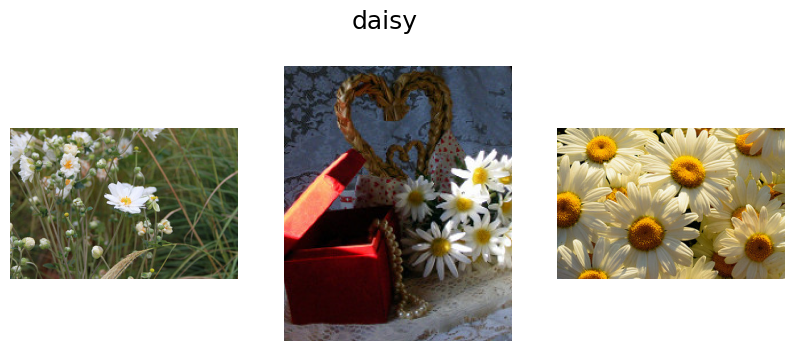

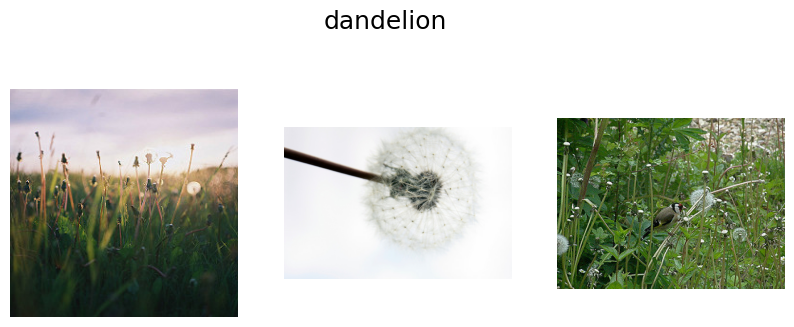

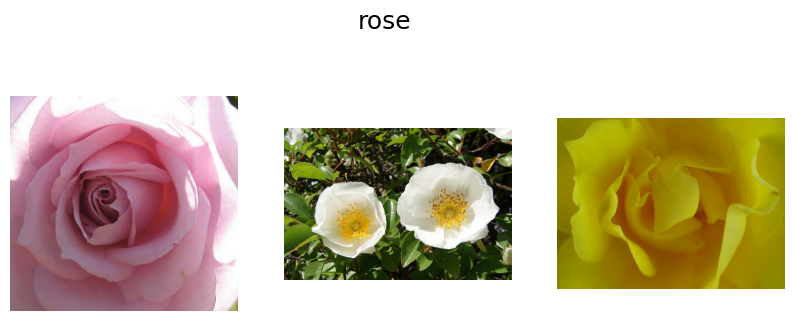

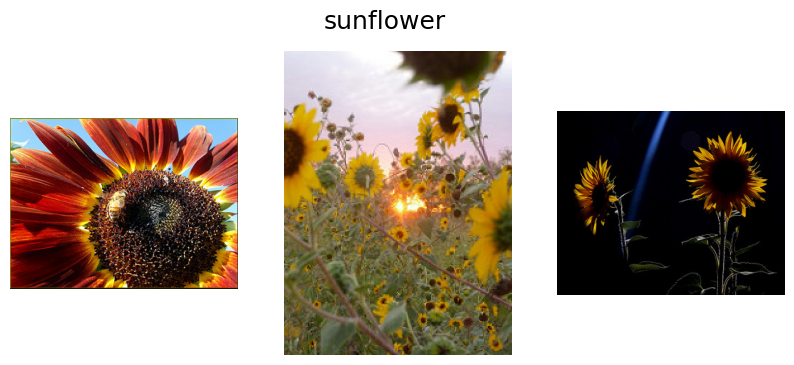

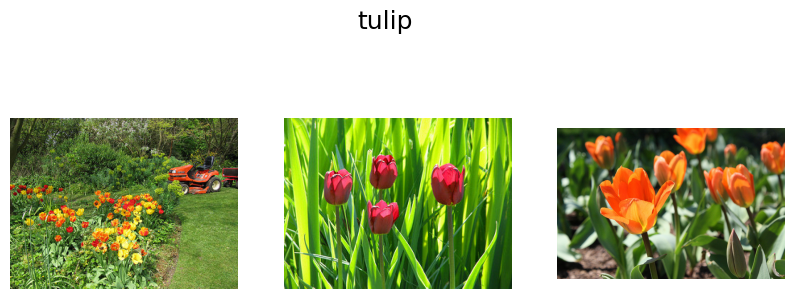

In [7]:
# visulaizing the images
for category in CATEGORIES:
  #constructing the path
  path = os.path.join(DATADIR, category)
  images = os.listdir(path)

  fig, ax = plt.subplots(1, 3, figsize = (10, 4))
  fig.suptitle(f'{category}', fontsize = 18)

  for i in range(3):
    img_name = images[np.random.randint(0, len(images))]
    img_path = os.path.join(path, img_name)
    img_array = cv2.imread(img_path)

    # converting the BGR images to RGB
    img_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

    ax[i].imshow(img_rgb)
    ax[i].axis('off')

In [8]:
def count_images(directory):
  for category in CATEGORIES:
    path = os.path.join(directory, category)
    images = os.listdir(path)
    num_images = len(images)
    print(f'{category} : {num_images} images')

count_images(DATADIR)

daisy : 501 images
dandelion : 646 images
rose : 497 images
sunflower : 495 images
tulip : 607 images


In [9]:
# data augmentation
transform = A.Compose([
    #horizontal flips
    A.HorizontalFlip(p=0.5),
    # scaling the image between 80% and 100% of its area, then resizing to 224x224
    A.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.8, 1.2), p=0.5),
    # changing the brightness of the images
    A.RandomBrightnessContrast(p=0.5),
    # rotating it between -25 to 25 degrees
    A.Rotate(limit=25, p=0.5)
])

def augment_images(directory, CATEGORIES):
  for category in CATEGORIES:
    path = os.path.join(directory, category)
    for filename in os.listdir(path):
      img = cv2.imread(os.path.join(path, filename))
      # Check if image is loaded successfully
      if img is None:
          print(f"Warning: Could not load image {os.path.join(path, filename)}")
          continue

      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      # Albumentations expects 'image' keyword argument and returns a dict
      augmented_img_dict = transform(image=img)
      augmented_img = augmented_img_dict['image']

      new_filename = os.path.splitext(filename)[0] + '_augmented' + os.path.splitext(filename)[1]
      # Convert back to BGR before saving with cv2
      cv2.imwrite(os.path.join(path, new_filename), cv2.cvtColor(augmented_img, cv2.COLOR_RGB2BGR))

augment_images(DATADIR, CATEGORIES)

In [10]:
count_images(DATADIR)

daisy : 1002 images
dandelion : 1292 images
rose : 994 images
sunflower : 990 images
tulip : 1214 images


In [11]:
img_array.shape

(333, 500, 3)

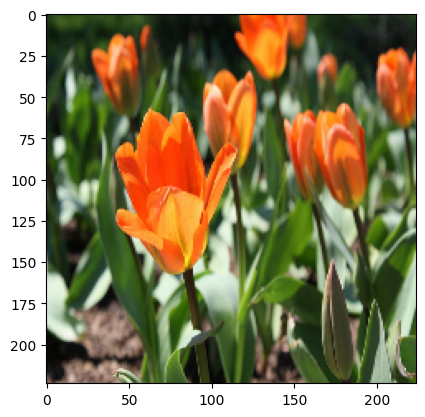

In [12]:
# resizing images
IMG_SIZE = 224
new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
img = cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [13]:
# creating training data
training_data = []

def create_training_data():
  for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    labels = CATEGORIES.index(category)
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path, img))
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        training_data.append([new_array, labels])
      except Exception as e:
        pass

create_training_data()

In [14]:
len(training_data)

5492

In [15]:
X = []
y = []

for features, label in training_data:
  X.append(features)
  y.append(label)

In [16]:
type(X), type(y)

(list, list)

In [17]:
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(y)

In [18]:
# train_test_split
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [19]:
print(f'X_train length : {X_train.shape[0]}, X_train Image Size : {X_train.shape[1:3]}, Channel Dimension : {X_train.shape[3]}')
print(f'X_test length : {X_test.shape[0]}, X_test Image Size : {X_test.shape[1:3]}, Channel Dimension : {X_test.shape[3]}')

X_train length : 4393, X_train Image Size : (224, 224), Channel Dimension : 3
X_test length : 1099, X_test Image Size : (224, 224), Channel Dimension : 3


In [20]:
efficient_net = EfficientNetB0(weights = 'imagenet',
                               include_top = False,
                               input_shape = (IMG_SIZE, IMG_SIZE, 3))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [21]:
# freezing the bottom layers
for layer in efficient_net.layers:
  layer.trainable = False

In [22]:
# constructing the FC(Dense) layers
model = keras.Sequential([
    efficient_net,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(1024, activation = 'relu'),
    keras.layers.Dense(512, activation = 'relu'),
    keras.layers.Dense(5, activation = 'softmax'),
])

model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

model.fit(X_train, y_train, epochs = 10, batch_size = 32)

Epoch 1/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 47s 139ms/step - accuracy: 0.8288 - loss: 0.4521
Epoch 2/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9711 - loss: 0.0952
Epoch 3/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9810 - loss: 0.0523
Epoch 4/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9914 - loss: 0.0281
Epoch 5/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9854 - loss: 0.0481
Epoch 6/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9901 - loss: 0.0331
Epoch 7/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9915 - loss: 0.0257
Epoch 8/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9925 - loss: 0.0248
Epoch 9/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9919 - loss: 0.0211
Epoch 10/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9864 - loss: 0.0334


In [23]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Model Accuracy : {accuracy * 100}')

35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 330ms/step - accuracy: 0.9555 - loss: 0.1569
Model Accuracy : 95.90536952018738


In [24]:
pred = np.argmax(model.predict(X_test), axis = -1)

35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 228ms/step


In [25]:
pred

array([4, 0, 4, ..., 0, 1, 4])

In [26]:
y_test[10:15]

array([1, 4, 3, 1, 3])

In [27]:
pred[10:15]

array([1, 4, 3, 1, 3])

In [28]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       214
           1       0.98      0.95      0.96       256
           2       0.95      0.92      0.93       182
           3       0.95      0.98      0.97       187
           4       0.93      0.97      0.95       260

    accuracy                           0.96      1099
   macro avg       0.96      0.96      0.96      1099
weighted avg       0.96      0.96      0.96      1099



Text(50.722222222222214, 0.5, 'ACTUAL')

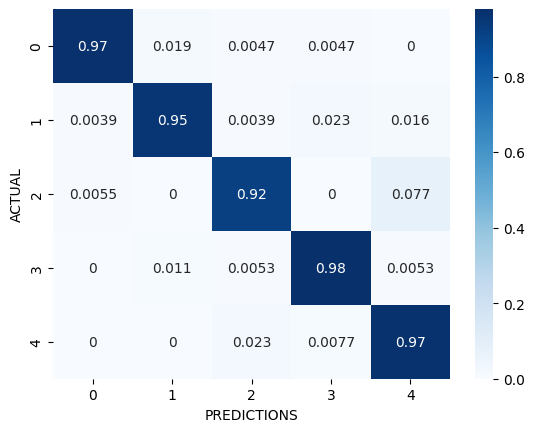

In [29]:
cf = confusion_matrix(y_test, pred, normalize = 'true')
sns.heatmap(cf, annot = True, cmap = 'Blues');
plt.xlabel('PREDICTIONS')
plt.ylabel('ACTUAL')